In [1]:
import ssms
import lanfactory
import os
import numpy as np
from copy import deepcopy
import torch

In [2]:
MODEL = "ddm"
RUN_SIMS = False

In [3]:
# Initialize the generator config (for MLP LANs)
generator_config = deepcopy(ssms.config.data_generator_config["lan"])
# Specify generative model (one from the list of included models mentioned above)
generator_config["dgp_list"] = MODEL
# Specify number of parameter sets to simulate
generator_config["n_parameter_sets"] = 256
# Specify how many samples a simulation run should entail
generator_config["n_samples"] = 2000
# Specify folder in which to save generated data
generator_config["output_folder"] = "data/lan_mlp/"

# Make model config dict
model_config = ssms.config.model_config[MODEL]

In [4]:
model_config

{'name': 'ddm',
 'params': ['v', 'a', 'z', 't'],
 'param_bounds': [[-3.0, 0.3, 0.1, 0.0], [3.0, 2.5, 0.9, 2.0]],
 'boundary': <function ssms.basic_simulators.boundary_functions.constant(t=0)>,
 'n_params': 4,
 'default_params': [0.0, 1.0, 0.5, 0.001],
 'hddm_include': ['z'],
 'nchoices': 2}

In [5]:
generator_config["output_folder"] = (
    "data/lan_mlp/"
    + generator_config["dgp_list"]
    + "/"
    + str(generator_config["n_samples"])
    + "_"
    + str(generator_config["n_training_samples_by_parameter_set"])
    + "/"
)

In [6]:
if RUN_SIMS:
    n_datafiles = 20
    for i in range(n_datafiles):
        print("Datafile: ", i)
        my_dataset_generator = ssms.dataset_generators.lan_mlp.data_generator(
            generator_config=generator_config, model_config=model_config
        )
        training_data = my_dataset_generator.generate_data_training_uniform(save=True)

In [7]:
import pickle

my_data = pickle.load(
    open(
        "data/lan_mlp/ddm/2000_1000//training_data_802269f0685a11ee8748ac1f6bfea5a4.pickle",
        "rb",
    )
)

In [8]:
my_data["choice_p"].shape

(250,)

In [9]:
my_data['thetas'].shape

(250, 4)

In [10]:
network_config = lanfactory.config.network_configs.network_config_mlp

print("Network config: ")
print(network_config)

train_config = lanfactory.config.network_configs.train_config_mlp

print("Train config: ")
print(train_config)

Network config: 
{'layer_sizes': [100, 100, 1], 'activations': ['tanh', 'tanh', 'linear'], 'train_output_type': 'logprob'}
Train config: 
{'cpu_batch_size': 128, 'gpu_batch_size': 256, 'n_epochs': 5, 'optimizer': 'adam', 'learning_rate': 0.002, 'lr_scheduler': 'reduce_on_plateau', 'lr_scheduler_params': {}, 'weight_decay': 0.0, 'loss': 'huber', 'save_history': True}


In [11]:
network_config["train_output_type"] = "logits"


train_config["loss"] = "bcelogit"
train_config["cpu_batch_size"] = 128
train_config["gpu_batch_size"] = 128
train_config["n_epochs"] = 20

In [12]:
folder_ = "data/lan_mlp/" + MODEL + "/2000_1000/"
file_list_ = [folder_ + file_ for file_ in os.listdir(folder_)]

# Training dataset
jax_training_dataset = lanfactory.trainers.DatasetTorch(
    file_ids=file_list_,
    batch_size=train_config["gpu_batch_size"]
    if torch.cuda.is_available()
    else train_config["cpu_batch_size"],
    label_lower_bound=np.log(1e-10),
    features_key="thetas",
    label_key="choice_p",
    out_framework="jax",
)

jax_training_dataloader = torch.utils.data.DataLoader(
    jax_training_dataset, shuffle=True, batch_size=None, num_workers=1, pin_memory=True
)

# Validation dataset
jax_validation_dataset = lanfactory.trainers.DatasetTorch(
    file_ids=file_list_,
    batch_size=train_config["gpu_batch_size"]
    if torch.cuda.is_available()
    else train_config["cpu_batch_size"],
    label_lower_bound=np.log(1e-10),
    features_key="thetas",
    label_key="choice_p",
    out_framework="jax",
)

jax_validation_dataloader = torch.utils.data.DataLoader(
    jax_validation_dataset,
    shuffle=True,
    batch_size=None,
    num_workers=1,
    pin_memory=True,
)

In [29]:
cnt = 0
for xb, yb in jax_training_dataloader:
    print(xb)
    print(yb)
    cnt += 1
    if cnt > 10:
        break

tensor([[ 1.3875,  1.0988,  0.4319,  0.6890],
        [ 2.0641,  0.5735,  0.4064,  1.0609],
        [ 0.3673,  2.4499,  0.1387,  0.5495],
        [ 0.1586,  2.4325,  0.8431,  1.9932],
        [-1.2530,  1.1292,  0.2656,  1.3690],
        [ 2.1943,  0.4761,  0.5051,  0.8956],
        [-2.8107,  1.7185,  0.7278,  1.5208],
        [ 1.4085,  1.4228,  0.4704,  0.1973],
        [-2.6501,  0.5449,  0.3855,  0.1303],
        [-1.1308,  1.1600,  0.1699,  1.9684],
        [ 2.5065,  1.1481,  0.4963,  0.8414],
        [-0.9240,  1.7089,  0.7574,  1.8790],
        [-1.8158,  0.8894,  0.3338,  0.1655],
        [ 1.2889,  2.0544,  0.5561,  1.9970],
        [ 0.9539,  1.7233,  0.5906,  0.2917],
        [ 1.1837,  1.6261,  0.7342,  1.5239],
        [ 2.2922,  0.8479,  0.2296,  0.1975],
        [ 2.3063,  0.6019,  0.5261,  0.1864],
        [ 2.7554,  1.2701,  0.2686,  0.5694],
        [ 2.6340,  1.3958,  0.3809,  0.9869],
        [ 0.8128,  2.0258,  0.3488,  0.0488],
        [ 0.9539,  1.7233,  0.5906

In [13]:
# LOAD NETWORK
jax_net = lanfactory.trainers.MLPJaxFactory(network_config=network_config, train=True)

In [14]:
jax_trainer = lanfactory.trainers.ModelTrainerJaxMLP(
    train_config=train_config,
    model=jax_net,
    train_dl=jax_training_dataloader,
    valid_dl=jax_validation_dataloader,
    pin_memory=True,
)

In [15]:
train_state = jax_trainer.train_and_evaluate(
    output_folder="data/trained_model/jax/",
    output_file_id=MODEL,
    run_id="test_run_notebook",
    wandb_on=True,
    wandb_project_id="test_run_notebook",
    save_data_details=True,
    verbose=1,
    save_all=True,
)

Found folder:  data
Moving on...
Found folder:  data/trained_model
Moving on...
Found folder:  data/trained_model/jax
Moving on...


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: afengler. Use `wandb login --relogin` to force relogin


Epoch: 0 of 20
Training - Step: 0 of 20 - Loss: 0.66841096
Epoch 0/20 time: 2.480642557144165s
Validation - Step: 0 of 20 - Loss: 0.3640096
Epoch 0/20 time: 0.711876392364502s
Epoch: 0 / 20, test_loss: 0.3763638436794281
Epoch: 1 of 20
Training - Step: 0 of 20 - Loss: 0.42096427
Epoch 1/20 time: 0.21535420417785645s
Validation - Step: 0 of 20 - Loss: 0.32862508
Epoch 1/20 time: 0.2097616195678711s
Epoch: 1 / 20, test_loss: 0.36423781514167786
Epoch: 2 of 20
Training - Step: 0 of 20 - Loss: 0.32760912
Epoch 2/20 time: 0.2090158462524414s
Validation - Step: 0 of 20 - Loss: 0.36396658
Epoch 2/20 time: 0.21240592002868652s
Epoch: 2 / 20, test_loss: 0.34704074263572693
Epoch: 3 of 20
Training - Step: 0 of 20 - Loss: 0.37704283
Epoch 3/20 time: 0.21966028213500977s
Validation - Step: 0 of 20 - Loss: 0.33193588
Epoch 3/20 time: 0.21724534034729004s
Epoch: 3 / 20, test_loss: 0.33903735876083374
Epoch: 4 of 20
Training - Step: 0 of 20 - Loss: 0.32506475
Epoch 4/20 time: 0.2142655849456787s
Vali

In [16]:
print(network_config)

{'layer_sizes': [100, 100, 1], 'activations': ['tanh', 'tanh', 'linear'], 'train_output_type': 'logits'}


In [17]:
# Loaded Net
jax_infer = lanfactory.trainers.MLPJaxFactory(
    network_config=network_config,
    train=False,
)

In [21]:
my_state = jax_infer.load_state_from_file(file_path = "data/trained_model/jax/test_run_notebook_cpn_ddm__train_state.jax")

passing through transform


In [22]:
forward_pass, forward_pass_jitted = jax_infer.make_forward_partial(
    seed=42,
    input_dim=model_config["n_params"] + 2,
    state="data/trained_model/jax/test_run_notebook_cpn_ddm__train_state.jax",
    add_jitted=True,
)

passing through transform


In [24]:
import jax.numpy as jnp
import numpy as np

# Test parameters:
v, a, z, t, theta = 0.5, 1.5, 0.5, 0.3, 0.3
v = np.linspace(-3, 3, 50)

# Comparison simulator run
choice_p_list = []
for v_tmp in v:
    print(v_tmp)
    sim_out = ssms.basic_simulators.simulator.simulator(
        model=MODEL, theta=[v_tmp, a, z, t, theta], n_samples=2000
    )
    choice_p_list.append(np.sum(sim_out['choices'] == 1.) / sim_out['choices'].shape[0])


# Make input matric
input_mat = jnp.zeros((50, 4))
input_mat = input_mat.at[:, 0].set(jnp.array(v))
input_mat = input_mat.at[:, 1].set(jnp.ones(50) * a)
input_mat = input_mat.at[:, 2].set(jnp.ones(50) * z)
input_mat = input_mat.at[:, 3].set(jnp.ones(50) * t)

net_out = forward_pass_jitted(input_mat)

-3.0
-2.877551020408163
-2.7551020408163267
-2.63265306122449
-2.510204081632653
-2.387755102040816
-2.2653061224489797
-2.142857142857143
-2.020408163265306
-1.8979591836734695
-1.7755102040816326
-1.653061224489796
-1.5306122448979593
-1.4081632653061225
-1.2857142857142858
-1.163265306122449
-1.0408163265306123
-0.9183673469387754
-0.795918367346939
-0.6734693877551021
-0.5510204081632653
-0.4285714285714288
-0.30612244897959195
-0.18367346938775508
-0.06122448979591866
0.06122448979591821
0.18367346938775508
0.30612244897959195
0.4285714285714284
0.5510204081632653
0.6734693877551021
0.7959183673469385
0.9183673469387754
1.0408163265306118
1.1632653061224492
1.2857142857142856
1.408163265306122
1.5306122448979593
1.6530612244897958
1.7755102040816322
1.8979591836734695
2.020408163265306
2.1428571428571423
2.2653061224489797
2.387755102040816
2.5102040816326525
2.63265306122449
2.7551020408163263
2.8775510204081627
3.0
passing through transform


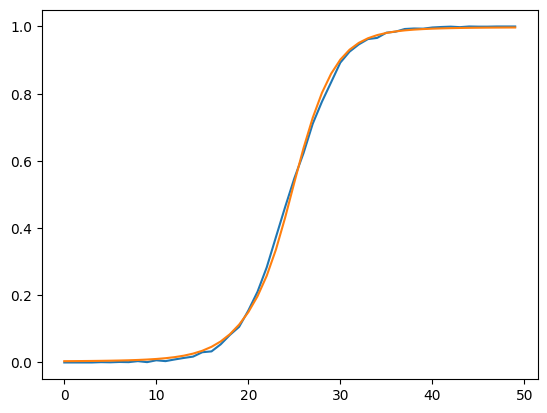

: 

In [29]:
from matplotlib import pyplot as plt
plt.plot(choice_p_list)
plt.plot(np.exp(net_out))